In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Loading data

In [7]:
import hashlib

# loading csv file as pandas dataframe
df = pd.read_csv("../data/podcast_data20240902-20241201.csv", dtype="unicode", low_memory=False)

# df = df.rename(columns={"Date:Time (evar16)":           "date_time",
                    #     "UserID Visit (evar95)":        "user_id",
                    #     "Production Number (evar35)":   "prd_number",
                    #     "Serietitel":                   "series_title",
                    #     "Unik titel":                   "unique_title",
                    #     "Platform (evar13)":            "platform",
                    #     "Mobile Device Type":           "device_type",
                    #     "Content Type (revar3)":        "content_type",
                    #     "Første Streaming Dato":        "pub_date",
                    #     "Video Length":                 "episode_duration",
                    #     "Genre":                        "genre",
                    #     "Branding Kanal":               "branding_channel",
                    #     "Moder Kanal":                  "mother_channel",
                    #     "Kategori":                     "category",
                    #     "Content Time Spent (revent1)": "content_time_spent"
                    #     }
                    # )

# Function to hash a string
def hash_string(s):
    return hashlib.sha256(s.encode()).hexdigest() if pd.notna(s) else None

# Apply hashing to the column
df['UserID Visit (evar95)'] = df['UserID Visit (evar95)'].apply(hash_string)

df

# TODO: define translation dict in a separate script named "config" or something similar

,Date:Time (evar16),UserID Visit (evar95),Production Number (evar35),Serietitel,Unik titel,Platform (evar13),Mobile Device Type,Content Type (revar3),Første Streaming Dato,Video Length,Genre,Branding Kanal,Moder Kanal,Kategori,Content Time Spent (revent1)
0,NaN,None,NaN,NaN,NaN,mobile web,Mobile Phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,None,NaN,NaN,NaN,web,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,01:09:2024|0:02,None,11802450013,Genstart,Genstart: Daisy giver slip_11802450013,app,Mobile Phone,vod,2024-01-03,1517,Aktualitet,DR Lyd,DR P1,Nyheder,133
3,01:09:2024|0:03,None,11032423341,Vildt Naturligt,Vildt Naturligt: Mere ilt - mere liv?_11032423341,app,Mobile Phone,vod,2024-08-19,3396,Fakta og debat,DR P1,DR P1,Oplysning og kultur,2404
4,01:09:2024|0:03,None,13332435356,Natradio på P3,Natradio på P3_13332435356,app,Tablet,live,2024-09-01,10620,Unge,-,P3,Musik,89882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43032697,31:10:2024|9:59,89339b7265b28161d6023e9f1eae95c22c2dbc85e354ac...,11802421042,Prompt,"Prompt: Chatbot-tragedie, spøgelset i maskinen...",app,Mobile Phone,NaN,2024-10-31,10800,Fakta og debat,DR Lyd,DR P1,Aktualitet og debat,0
43032698,31:10:2024|9:59,89339b7265b28161d6023e9f1eae95c22c2dbc85e354ac...,11802421042,Prompt,"Prompt: Chatbot-tragedie, spøgelset i maskinen...",app,Mobile Phone,live,2024-10-31,10800,Fakta og debat,DR Lyd,DR P1,Aktualitet og debat,223
43032699,31:10:2024|9:59,898e002d37d571ae6de2f356da8626c3373651382c5e74...,14202420444,P4 Morgen Midt & Vest,P4 Morgen_14202420444,app,Mobile Phone,live,2024-10-31,10920,Aktualitet,P4 Midt & Vest,P4 Midt & Vest,Aktualitet og debat,85
43032700,31:10:2024|9:59,44b1bfcb3e7749d0ad545b5fce13a35761f41d3c19d487...,NaN,NaN,NaN,mobile web,Mobile Phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [8]:
df.to_parquet("../data/podcast_data_20240902-20241201_hashed.parquet")

### Filtering data

In [ ]:
# changing the datatype for the content time spent column
df["content_time_spent"] = df["content_time_spent"].astype(int)

# filtering the dataframe
filtered_df = df[(df["user_id"].notna()) & 
                 (df["prd_number"].notna()) & 
                 (df["content_type"] == "vod")
                 ]

# dropping the content_type attribute
filtered_df.drop(columns=["content_type"], inplace=True)

# only including relevant mobile device types
main_devices = {"Mobile Phone", "Other", "Tablet"}
filtered_df = filtered_df[filtered_df["device_type"].isin(main_devices)]

# excluding some combinations of platform and mobile device type
exclude_combinations = {("mobile web", "Other"), ("web", "Mobile Phone"), ("web", "Tablet")}
filtered_df = filtered_df.loc[~df[["platform", "device_type"]].apply(tuple, axis=1).isin(exclude_combinations)]

In [ ]:
# grouping rows by user_id and prd_number
filtered_df["date_time"] = pd.to_datetime(filtered_df["date_time"], format="%d:%m:%Y|%H:%M")
cts_grp_df = filtered_df.groupby(["user_id", "prd_number"]).agg(
    date_time =             ("date_time",           lambda x: x.loc[df.loc[x.index, "content_time_spent"].idxmax()]),
    series_title =          ("series_title",        "first"),
    unique_title =          ("unique_title",        "first"),
    platform =              ("platform",            "first"),
    device_type =           ("device_type",         "first"),
    pub_date =              ("pub_date",            "first"),
    episode_duration =      ("episode_duration",    "first"),
    genre =                 ("genre",               "first"),
    branding_channel =      ("branding_channel",    "first"),
    mother_channel =        ("mother_channel",      "first"),
    category =              ("category",            "first"),
    content_time_spent =    ("content_time_spent",  "sum")
).reset_index()

# filtering on content time spent
cts_grp_df = cts_grp_df[(cts_grp_df["content_time_spent"] > 60)]
cts_grp_df
# TODO: Filter on users who have listened to x episodes across the period
# TODO: Filter on series/episodes listened by less than x users

,user_id,prd_number,date_time,series_title,unique_title,platform,device_type,pub_date,episode_duration,genre,branding_channel,mother_channel,category,content_time_spent
2,00005776ec874bc9ab8ca964cf274858,11032415372,2024-09-10 14:44:00,Kampen om historien,Kampen om historien: Jihadismen og kampen mod ...,app,Mobile Phone,2024-09-10,3416,Historie,DR P1,DR P1,Oplysning og kultur,1140
3,00005776ec874bc9ab8ca964cf274858,11032415392,2024-10-08 10:51:00,Kampen om historien,Kampen om historien: Midt i en ny mellemkrigst...,app,Mobile Phone,2024-09-24,3416,Historie,DR P1,DR P1,Oplysning og kultur,1257
4,00005776ec874bc9ab8ca964cf274858,11032415412,2024-11-28 09:42:00,Kampen om historien,Kampen om historien: Gaskamrene er en detalje ...,app,Mobile Phone,2024-10-08,3393,Historie,DR P1,DR P1,Oplysning og kultur,3395
5,00005776ec874bc9ab8ca964cf274858,11032415422,2024-10-30 09:39:00,Kampen om historien,Kampen om historien: Libanons lange krig - kri...,app,Mobile Phone,2024-10-15,3427,Historie,DR P1,DR P1,Oplysning og kultur,3425
6,00005776ec874bc9ab8ca964cf274858,11032415432,2024-12-01 10:27:00,Kampen om historien,Kampen om historien: Hvad har amerikanerne lær...,app,Mobile Phone,2024-10-22,3365,Historie,DR P1,DR P1,Oplysning og kultur,4681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408287,fffdd9e933a748d2b8401bc936751fbe,11802433394,2024-09-26 19:02:00,P1 Morgen,P1 Morgen_11802433394,app,Mobile Phone,2024-09-26,9881,Aktualitet,DR P1,DR P1,Aktualitet og debat,1027
3408288,fffdd9e933a748d2b8401bc936751fbe,11802450391,2024-09-24 07:14:00,Genstart,Genstart: Gisèle vender skammen_11802450391,app,Mobile Phone,2024-09-23,1384,Aktualitet,DR Lyd,DR P1,Nyheder,1373
3408289,fffdd9e933a748d2b8401bc936751fbe,11802450392,2024-09-24 07:37:00,Genstart,Genstart: Fluernes herre_11802450392,app,Mobile Phone,2024-09-24,1450,Aktualitet,DR Lyd,DR P1,Nyheder,315
3408290,fffdd9e933a748d2b8401bc936751fbe,11802450402,2024-10-03 19:12:00,Genstart,Genstart: Diez og bedraget_11802450402,app,Mobile Phone,2024-10-01,1826,Aktualitet,DR Lyd,DR P1,Nyheder,1583


### Transforming data

In [ ]:
# defining df as transformed_df
transformed_df = filtered_df

# transforming episode duration to float
transformed_df["episode_duration"] = (
    filtered_df["episode_duration"]
    .astype(int) 
)

# splitting the Date:Time column into two separate columns
transformed_df[["date", "time"]] = filtered_df["date_time"].str.split("|", expand=True)
transformed_df["date"] = transformed_df["date"].str.replace(":", "-")
transformed_df["date"] = pd.to_datetime(transformed_df["date"], format="%d-%m-%Y")
transformed_df["time"] = transformed_df["time"].str.zfill(5)
transformed_df.drop(columns=["date_time"], inplace=True)

# filter out dates that are before 
start_date = "2024-09-02"
end_date = "2024-12-01"
transformed_df = transformed_df[(transformed_df["date"] >= start_date) & (transformed_df["date"] <= end_date)]

# computing completion rate
transformed_df["completion_rate"] = np.where(
    transformed_df["content_time_spent"] > transformed_df["episode_duration"],
    1,
    transformed_df["content_time_spent"] / transformed_df["episode_duration"]
)

# renaming variable values
transformed_df["platform"] = df["platform"].replace({"mobile web": "Web"})
transformed_df["device_type"] = df["device_type"].replace({"Other": "PC"})


# TODO: split "unik titel" column to obtain episode title

transformed_df

C:\Users\sewr\AppData\Local\Temp\ipykernel_18440\2130703973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df["episode_duration"] = (
C:\Users\sewr\AppData\Local\Temp\ipykernel_18440\2130703973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_df[["date", "time"]] = filtered_df["date_time"].str.split("|", expand=True)
C:\Users\sewr\AppData\Local\Temp\ipykernel_18440\2130703973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,user_id,prd_number,series_title,unique_title,platform,device_type,content_type,pub_date,episode_duration,genre,branding_channel,mother_channel,category,content_time_spent,date,time,completion_rate
8609,02f3e71af3c545d1a7a6d950ea2503ad,16122492608,Djævlen i detaljen,Djævlen i detaljen: En opdigtet morder 3:3 - M...,app,Mobile Phone,vod,2024-02-28,2004,Fakta og debat,DR Lyd,-,Oplysning og kultur,1998,2024-10-01,00:00,0.997006
8620,2e319a49447561dcaccc4f7e481da11e,16122492633,Djævlen i detaljen,"Djævlen i detaljen: Døgnet, der rystede Danmar...",app,Mobile Phone,vod,2024-09-25,1767,Fakta og debat,DR Lyd,-,Oplysning og kultur,1760,2024-10-01,00:00,0.996038
8628,4047cd5fc6ed4f1fbdee29f3b21fcfc2,11802450401,Genstart,Genstart: Det vilde vest_11802450401,app,Mobile Phone,vod,2024-09-30,1674,Aktualitet,DR Lyd,DR P1,Nyheder,1674,2024-10-01,00:00,1.000000
8630,58805dd64e80384b68e5a82831f0cce,11032202001,Radiofortællinger,Radiofortællinger - Turist i Eritrea_11032202001,app,Mobile Phone,vod,2022-03-13,1997,Fakta og debat,NaN,-,Oplysning og kultur,1879,2024-10-01,00:00,0.940911
8634,5f51a517b2a64a8f902d58e4c3fbc066,11802401169,Udsyn,Udsyn: Fænomenet Trump_11802401169,app,Mobile Phone,vod,2024-09-26,1797,Nyheder,DR P1,DR P1,Aktualitet og debat,585,2024-10-01,00:00,0.325543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43032668,cd59d1d7f7544b62a742b64bf2a8bd48,16122492418,Krig,Krig: Bomberydderen_16122492418,app,Mobile Phone,vod,2024-10-16,2844,Fakta og debat,DR Lyd,-,Oplysning og kultur,900,2024-10-31,09:59,0.316456
43032669,d05af853ba5ce13c98cd59cf9f72e1c7,11802451177,Tiden,"Tiden: Gemte adoptionspapirer, svindelfrygt i ...",app,Mobile Phone,vod,2024-10-31,952,Nyheder,DR Lyd,-,Nyheder,944,2024-10-31,09:59,0.991597
43032684,db8cac4c532ebe6144fa4bc890e84404,13332496437,Kapitalisterne,"Kapitalisterne: Trump vinder valget, og Kong F...",app,Mobile Phone,vod,2024-10-25,3748,Unge,DR Lyd,-,Oplysning og kultur,3209,2024-10-31,09:59,0.856190
43032685,de3e1ebf2567636de7d417dd89e3a400,11032415442,Kampen om historien,Kampen om historien: Vietnamkrigen - USA's stø...,app,Mobile Phone,vod,2024-10-29,3412,Historie,DR P1,DR P1,Oplysning og kultur,164,2024-10-31,09:59,0.048066


### Episode descriptions

In [ ]:
# loading the short description data
descr_df = pd.read_csv("../data/prd_shortdescr.csv", dtype="unicode", low_memory=False)

# renaming the columns
descr_df = descr_df.rename(columns={"PRD_NUMBER":       "prd_number",
                                    "PRD_SHORTDESCR":   "prd_shortdescr",
                    }
                )

# left joining onto the main dataframe
transformed_df_w_descr = pd.merge(transformed_df, descr_df, on="prd_number", how="left")
transformed_df_w_descr

,user_id,prd_number,series_title,unique_title,platform,device_type,content_type,pub_date,episode_duration,genre,branding_channel,mother_channel,category,content_time_spent,date,time,completion_rate,prd_shortdescr
0,02f3e71af3c545d1a7a6d950ea2503ad,16122492608,Djævlen i detaljen,Djævlen i detaljen: En opdigtet morder 3:3 - M...,app,Mobile Phone,vod,2024-02-28,2004,Fakta og debat,DR Lyd,-,Oplysning og kultur,1998,2024-10-01,00:00,0.997006,Jane Fisher finder nu den afgørende puslespils...
1,2e319a49447561dcaccc4f7e481da11e,16122492633,Djævlen i detaljen,"Djævlen i detaljen: Døgnet, der rystede Danmar...",app,Mobile Phone,vod,2024-09-25,1767,Fakta og debat,DR Lyd,-,Oplysning og kultur,1760,2024-10-01,00:00,0.996038,En lørdag eftermiddag for knap 10 år siden pra...
2,4047cd5fc6ed4f1fbdee29f3b21fcfc2,11802450401,Genstart,Genstart: Det vilde vest_11802450401,app,Mobile Phone,vod,2024-09-30,1674,Aktualitet,DR Lyd,DR P1,Nyheder,1674,2024-10-01,00:00,1.000000,Det frisindede Californien hvor solen altid sk...
3,58805dd64e80384b68e5a82831f0cce,11032202001,Radiofortællinger,Radiofortællinger - Turist i Eritrea_11032202001,app,Mobile Phone,vod,2022-03-13,1997,Fakta og debat,NaN,-,Oplysning og kultur,1879,2024-10-01,00:00,0.940911,Forfatteren Trine Andersen er rejst til Eritre...
4,5f51a517b2a64a8f902d58e4c3fbc066,11802401169,Udsyn,Udsyn: Fænomenet Trump_11802401169,app,Mobile Phone,vod,2024-09-26,1797,Nyheder,DR P1,DR P1,Aktualitet og debat,585,2024-10-01,00:00,0.325543,Efter tv-debatten mellem Donald Trump og Kamal...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648659,cd59d1d7f7544b62a742b64bf2a8bd48,16122492418,Krig,Krig: Bomberydderen_16122492418,app,Mobile Phone,vod,2024-10-16,2844,Fakta og debat,DR Lyd,-,Oplysning og kultur,900,2024-10-31,09:59,0.316456,Den erfarne bomberydder Ole fortæller om det n...
3648660,d05af853ba5ce13c98cd59cf9f72e1c7,11802451177,Tiden,"Tiden: Gemte adoptionspapirer, svindelfrygt i ...",app,Mobile Phone,vod,2024-10-31,952,Nyheder,DR Lyd,-,Nyheder,944,2024-10-31,09:59,0.991597,Danmarks sidste adoptionsbureau lukker og sluk...
3648661,db8cac4c532ebe6144fa4bc890e84404,13332496437,Kapitalisterne,"Kapitalisterne: Trump vinder valget, og Kong F...",app,Mobile Phone,vod,2024-10-25,3748,Unge,DR Lyd,-,Oplysning og kultur,3209,2024-10-31,09:59,0.856190,Der er vildt gang i de finansielle markeder. D...
3648662,de3e1ebf2567636de7d417dd89e3a400,11032415442,Kampen om historien,Kampen om historien: Vietnamkrigen - USA's stø...,app,Mobile Phone,vod,2024-10-29,3412,Historie,DR P1,DR P1,Oplysning og kultur,164,2024-10-31,09:59,0.048066,"""Jeg synes, at læren af fortiden i Vietnam er ..."


### Bookmark data

In [ ]:
# loading bookmark data
bookmark_df = pd.read_csv("../data/podcast_series_bookmark20240902-20241201.csv", dtype="unicode", low_memory=False)
bookmark_df = bookmark_df.rename(columns={"Date:Time (evar16)": "date_time",
                                          "UserID Visit (evar95)": "user_id",
                                          "Page Name (evar1)": "page_name",
                                          "App Activity Name (evar42)": "app_activity_name"
                                          }
                                        )

# filtering bookmark data
filtered_bookmark = bookmark_df[(bookmark_df["UserID Visit (evar95)"].notna()) & 
                                (bookmark_df["Page Name (evar1)"].str.contains(r'\bbookmark\b(?! opened)', case=False, na=False, regex=True))]

# splitting the Date:Time column into two separate columns
transformed_bookmark = filtered_bookmark
transformed_bookmark[["date", "time"]] = transformed_bookmark["Date:Time (evar16)"].str.split("|", expand=True)
transformed_bookmark["date"] = transformed_bookmark["date"].str.replace(":", "-")
transformed_bookmark["date"] = pd.to_datetime(transformed_bookmark["date"], format="%d-%m-%Y")
transformed_bookmark['time'] = transformed_bookmark['time'].str.zfill(5)
transformed_bookmark.drop(columns=["Date:Time (evar16)"], inplace=True)

# filter out dates that are before 
start_date = "2024-09-02"
end_date = "2024-12-01"
transformed_bookmark = transformed_bookmark[(transformed_bookmark["date"] >= start_date) & (transformed_bookmark["date"] <= end_date)]

transformed_bookmark;

C:\Users\sewr\AppData\Local\Temp\ipykernel_19372\501971454.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_bookmark[["date", "time"]] = transformed_bookmark["Date:Time (evar16)"].str.split("|", expand=True)
C:\Users\sewr\AppData\Local\Temp\ipykernel_19372\501971454.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_bookmark[["date", "time"]] = transformed_bookmark["Date:Time (evar16)"].str.split("|", expand=True)
C:\Users\sewr\AppData\Local\Temp\ipykernel_19372\501971454.py:11

,UserID Visit (evar95),Page Name (evar1),App Activity Name (evar42),date,time
5956,603865011451902253990599bedab690,app:radio android:bookmark,urn:dr:radio:series:6357f678255cdd28fb9fb0c8,2024-10-01,00:00
6235,603865011451902253990599bedab690,app:radio android:bookmark,urn:dr:radio:series:63d1b6d2f538158492649af9,2024-10-01,00:01
6593,efa20a87f73d4f4397c0b3c4321c7279,app:radio ios:bookmark,urn:dr:radio:series:618c5172c928eef30f91d62d,2024-10-01,00:02
6984,f0c9792dbf284e759e3f0f2c84b41f1c,app:radio ios:bookmark,urn:dr:radio:series:5fa15704da351264f87b46ce,2024-10-01,00:03
7682,e1c5699612e0412803051de8b2361d8a,app:radio android:bookmark,urn:dr:radio:series:65857ad8163dfa22d54c3d73,2024-10-01,00:06
...,...,...,...,...,...
50357699,4ab19f20a4014e90ae3a0e84c5c32a89,app:radio ios:bookmark,urn:dr:radio:series:626931758679fdf8af8a0e26,2024-10-31,09:58
50358229,6e16613e61914bfa851323b2ecda07a6,app:radio ios:bookmark,urn:dr:radio:series:5fa15787da351264f87b4a03,2024-10-31,09:59
50358230,6e16613e61914bfa851323b2ecda07a6,app:radio ios:bookmark,urn:dr:radio:series:5fa2950b330eac2f135bbad5,2024-10-31,09:59
50358284,9975dc469f714c6da89f654de81f76c0,app:radio ios:bookmark,urn:dr:radio:series:65857ad8163dfa22d54c3d73,2024-10-31,09:59


In [4]:
# checking if each user only occurs once for each series
grouped_bookmark = filtered_bookmark.groupby(['UserID Visit (evar95)', 'App Activity Name (evar42)']).size().reset_index(name='Count')

print(grouped_bookmark)

                   UserID Visit (evar95)  \
0       00005776ec874bc9ab8ca964cf274858   
1       00005776ec874bc9ab8ca964cf274858   
2       00005776ec874bc9ab8ca964cf274858   
3       00005776ec874bc9ab8ca964cf274858   
4       000208955b304a77a152a75ce7e9ad3e   
...                                  ...   
109489  fffdd9e933a748d2b8401bc936751fbe   
109490  fffdd9e933a748d2b8401bc936751fbe   
109491  fffdd9e933a748d2b8401bc936751fbe   
109492  fffdd9e933a748d2b8401bc936751fbe   
109493  fffdd9e933a748d2b8401bc936751fbe   

                          App Activity Name (evar42)  Count  
0       urn:dr:radio:series:5fa25ef8330eac2f135b62d6      1  
1       urn:dr:radio:series:5fa2605b330eac2f135b6a3f      1  
2       urn:dr:radio:series:610bd147214d9c8f19f2e2d2      1  
3       urn:dr:radio:series:65857ad8163dfa22d54c3d73      1  
4       urn:dr:radio:series:5fa25a95330eac2f135b4a6c      1  
...                                              ...    ...  
109489  urn:dr:radio:series:626931758

In [ ]:
# loading the programURN data
prgURN_df = pd.read_csv("../data/programURN_serietitel20240902-20241201.csv", dtype="unicode", low_memory=False)

# renaming columns
prgURN_df = prgURN_df.rename(columns={"programURN": "prg_urn",
                                      "Serietitel": "series_title"
                                      }
                                    )

# filtering out null values
prgURN_df = prgURN_df[(prgURN_df["Program URN (evar36)"].notna()) &
                      (prgURN_df["Serietitel"].notna())]
                       
prgURN_df

,Program URN (evar36),Serietitel
22,4c855f31-47bd-4b34-b8d0-cc494225b6e6,P5 Det er Dansk
27,53478d77-9050-462a-b545-733afa09a4d2,Forbrydelsen
33,75119426-45d9-4a92-8347-4bbbc8de9a81,P6 Beatet
39,91db538e-118b-4a57-9beb-de22c54fb4f1,P6 Beatet
42,a66360c3-7293-4bc8-b588-07d2bc6734e1,Klassen
...,...,...
50820,urn:dr:radio:series:671619131e23230d78149b3a,Indersiden med Viktor Fischer
50821,urn:dr:radio:series:671a2ec4c0065080aad24ca4,P6 Lytter
50822,urn:dr:radio:series:67221676832f7a5b818dba3c,Hystadejournalen
50823,urn:dr:radio:series:67368338504ff50e9461e4f3,P2 Prisen - De 5 bedste 2024


### Content time vs. duration investigation

In [ ]:
# for some entries, the content time spent > video length
# happens in case of rewinding 
# maybe also if episode gets stuck

# transformed_df[transformed_df["Content Time Spent (revent1)"] > transformed_df["Video Length"]]

### EDA

In [9]:
# option to view entire pandas outputs 
# pd.set_option('display.max_rows', None)

# line of code to cancel the above display setting
# pd.reset_option('all')

Checking data types of each variable:

In [10]:
transformed_df.dtypes

UserID Visit (evar95)                   object
Production Number (evar35)              object
Serietitel                              object
Unik titel                              object
Platform (evar13)                       object
Mobile Device Type                      object
Content Type (revar3)                   object
Første Streaming Dato                   object
Video Length                             int64
Genre                                   object
Branding Kanal                          object
Moder Kanal                             object
Kategori                                object
Content Time Spent (revent1)             int64
date                            datetime64[ns]
time                                    object
completion_rate                        float64
dtype: object

Summary statistics:

In [11]:
# display floats as they are instead of in scientific notation (e.g. e+04)
pd.options.display.float_format = '{:,.2f}'.format

# counting distinct users, series, and episodes
n_users = transformed_df["UserID Visit (evar95)"].nunique()
n_series = transformed_df["Serietitel"].nunique()
n_episodes = transformed_df["Production Number (evar35)"].nunique()
print(f"Number of uniques: \n- Users:\t{n_users}\n- Series:\t{n_series}\n- Episodes:\t{n_episodes}")

# numerical summaries of video length 
duration_summary = transformed_df["Video Length"].describe()
print("\n")
print("Summary of video length:")
print(duration_summary)
print("\n")

# numerical summary of content time spent 
time_spent_summary = transformed_df["Content Time Spent (revent1)"].describe()
print("Summary of content time spent:")
print(time_spent_summary)
print("\n")

# numerical summary of completion rate
completion_summary = transformed_df["completion_rate"].describe()
print("Summary of completion rate:")
print(completion_summary)
print("\n")

Number of uniques: 
- Users:	144001
- Series:	617
- Episodes:	22589


Summary of video length:
count   3,648,664.00
mean        2,845.20
std         1,970.15
min            21.00
25%         1,560.00
50%         2,277.00
75%         3,421.00
max        28,620.00
Name: Video Length, dtype: float64


Summary of content time spent:
count   3,648,664.00
mean        1,601.92
std         1,561.12
min            61.00
25%           652.00
50%         1,388.00
75%         2,038.00
max       426,294.00
Name: Content Time Spent (revent1), dtype: float64


Summary of completion rate:
count   3,648,664.00
mean            0.63
std             0.36
min             0.00
25%             0.28
50%             0.71
75%             1.00
max             1.00
Name: completion_rate, dtype: float64




Unique listeners per episode:

In [12]:
# Group by "episodeID" and calculate the count of distinct "userID"
unique_listeners = transformed_df.groupby("Production Number (evar35)")["UserID Visit (evar95)"].nunique().reset_index()

# Rename columns for clarity
unique_listeners.columns = ["prd_number", "unique_listeners"]

# Sort by the number of unique listeners in descending order
unique_listeners = unique_listeners.sort_values(by="unique_listeners", ascending=False).reset_index(drop=True)

# Display the result
print(unique_listeners)

        prd_number  unique_listeners
0      11802450402             12758
1      16122492630             11725
2      16122493781             10275
3      16122493791             10084
4      16122492631              9928
...            ...               ...
22584  14302408403                 1
22585  14302408406                 1
22586  14302408407                 1
22587  14302408423                 1
22588  14302408424                 1

[22589 rows x 2 columns]


Unique episodes per user:

In [13]:
# Group by "episodeID" and calculate the count of distinct "userID"
unique_episodes = transformed_df.groupby("UserID Visit (evar95)")["Production Number (evar35)"].nunique().reset_index()

# Rename columns for clarity
unique_episodes.columns = ["userID", "unique_episodes"]

# Sort by the number of unique listeners in descending order
unique_episodes = unique_episodes.sort_values(by="unique_episodes", ascending=False).reset_index(drop=True)

# Display the result
print(unique_episodes)

                                  userID  unique_episodes
0       2be981041851708fe138da159ea631a1             2386
1        63c1dd82fdbb3b3ba8e1c5794bca93b             2203
2       35114ddc8f304a3ab1504275642697d0             1526
3       ae5e3a1bb8a84a43a309d62bf55f4a26              928
4       035cf638fe6a428297077df35d417ce3              815
...                                  ...              ...
143996  5a96be3aabb34f2bbac1e050836d1214                1
143997  5a9983b80594497d9dcf9987562d0afa                1
143998  5a99c471325b46aab578ae8017920d29                1
143999  5a7acdd758b15a43a8a3208d6e01d4b7                1
144000  0007fac67122468db89e0ed4f7adb923                1

[144001 rows x 2 columns]


Text(0, 0.5, 'frequency')

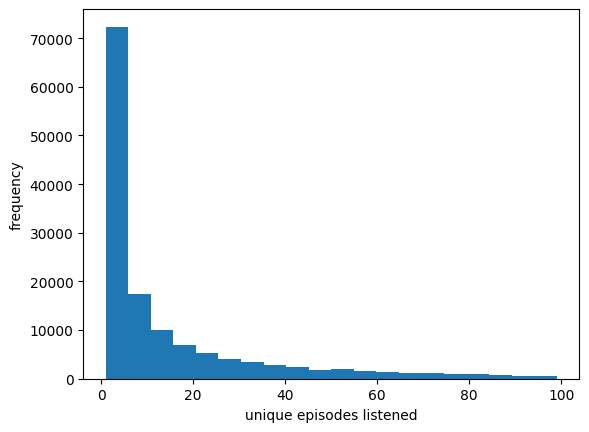

In [14]:
# the distribution of unique episodes per user is skewed
# trying to plot a histogram for users with a lower number of unique episodes listened to
low_unique_episodes = unique_episodes[unique_episodes["unique_episodes"] < 100]
plt.hist(low_unique_episodes["unique_episodes"], bins=20)
plt.xlabel("unique episodes listened")
plt.ylabel("frequency")

In [15]:
transformed_df["UserID Visit (evar95)"].value_counts()

UserID Visit (evar95)
2be981041851708fe138da159ea631a1    2435
63c1dd82fdbb3b3ba8e1c5794bca93b     2344
35114ddc8f304a3ab1504275642697d0    1724
566d0d1425f14e7cb63e206ff23b8892    1114
ae5e3a1bb8a84a43a309d62bf55f4a26    1057
                                    ... 
5a9983b80594497d9dcf9987562d0afa       1
f23580a6b55d4ce4bacc0decc3edc266       1
2c4e5467cdef4332a5ae8a6e5f76199a       1
b3c7417b454544c29b4bf42f8750e287       1
885b596ad45eb98c1b52e417dedcb65        1
Name: count, Length: 144001, dtype: int64

In [16]:
transformed_df["Production Number (evar35)"].value_counts()

Production Number (evar35)
11802450402    15240
16122492630    14936
16122493781    13371
15452448037    13301
16122493791    13025
               ...  
14302416444        1
14102416486        1
14702412443        1
14032412443        1
14032413443        1
Name: count, Length: 22589, dtype: int64

In [17]:
transformed_df["Serietitel"].value_counts()

Serietitel
Genstart                           552655
Djævlen i detaljen                 209854
Tiden                              194290
Sara & Monopolet - podcast         182194
Stjerner og striber                164225
                                    ...  
Festivalsommer                          2
Jydekrogen                              1
Bruce Springsteen - Born to run         1
DR Romanprisen 2017                     1
P8                                      1
Name: count, Length: 617, dtype: int64

In [18]:
transformed_df["Platform (evar13)"].value_counts()

Platform (evar13)
app    3484547
web     134100
Web      30017
Name: count, dtype: int64

In [19]:
transformed_df["Mobile Device Type"].value_counts()

Mobile Device Type
Mobile Phone    3401122
PC               227914
Tablet            19628
Name: count, dtype: int64

In [20]:
counts = transformed_df.groupby(["Platform (evar13)", "Mobile Device Type"]).size().reset_index(name='counts')
counts

,Platform (evar13),Mobile Device Type,counts
0,Web,Mobile Phone,27980
1,Web,Tablet,2037
2,app,Mobile Phone,3373142
3,app,PC,93814
4,app,Tablet,17591
5,web,PC,134100


In [21]:
transformed_df["Genre"].value_counts()

Genre
Fakta og debat     936020
Aktualitet         930306
Nyheder            422473
Livsstil           341318
Unge               308502
Kultur             179096
Musik              157126
Historie           122206
-                  121766
Dokumentar          45942
Sport               37930
Underholdning        4232
NN                   3562
Kor og orkestre        16
Name: count, dtype: int64

"Kanal" og "Branding Kanal" ser ud til at være det samme.

In [22]:
transformed_df["Moder Kanal"].value_counts()

Moder Kanal
-                  1922344
DR P1              1418941
P4 Fælles           128021
DR P2                38577
P3                   26547
DR P6 BEAT           23558
DR P5                23262
DR P8 JAZZ           11947
P1                    3153
P4 Fyn                1486
P4 København          1431
P4 Nordjylland         933
P4 Sjælland            779
P4 Midt & Vest         757
P4 Østjylland          719
P4 Bornholm            603
DR Kultur              510
P4 Syd                 496
DR LYD ekstra 2        409
DR LYD ekstra          306
P4 Trekanten           226
DR Politik             185
DR P2 Plus             185
DR Plus                184
P4 Esbjerg              60
Name: count, dtype: int64

In [23]:
transformed_df["Branding Kanal"].value_counts()

Branding Kanal
DR Lyd            1517168
DR P1             1137327
P3                 334228
P4 Fælles          325840
-                   49546
DR P2               43549
dr.dk radio         41865
DR P6 BEAT          31474
DR P5               22078
DR P8 JAZZ          12102
P4 Fyn               1486
P4 København         1431
P4 Nordjylland        933
P4 Sjælland           779
P4 Midt & Vest        757
P4 Østjylland         719
P4 Bornholm           603
P4 Syd                498
DR LYD ekstra         306
P4 Trekanten          226
P4 Esbjerg             58
Name: count, dtype: int64

In [24]:
transformed_df["Kategori"].value_counts()

Kategori
Oplysning og kultur         1329101
Nyheder                     1028273
Aktualitet og debat          918260
Musik                        251010
Underholdning                 74641
Sport                         38282
Dramatik og fiktion            6499
Udsendelsesvirksomhed          1870
Præsentation og services        728
Name: count, dtype: int64

Histogram of completion rate

Text(0, 0.5, 'density')

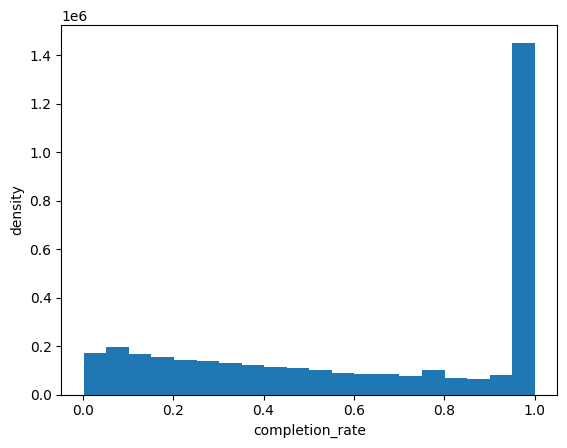

In [25]:
plt.hist(transformed_df["completion_rate"], bins=20)
plt.xlabel("completion_rate")
plt.ylabel("density")

Text(0, 0.5, 'density')

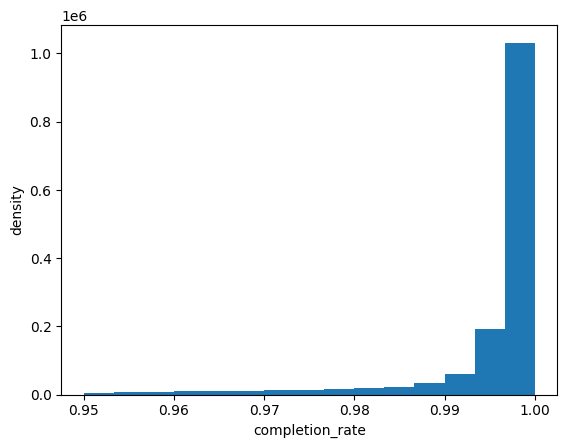

In [26]:
# histogram for completion rates > 0.9
high_rates = transformed_df[transformed_df["completion_rate"] > 0.95]
plt.hist(high_rates["completion_rate"], bins=15)
plt.xlabel("completion_rate")
plt.ylabel("density")